# Imports

In [1]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 977.3/977.3 kB 14.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [3]:
model_file = "/kaggle/working/yolo11-baseline.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80 # number of classes
scales:
  # [depth, width, max_channels]
  n: [0.50, 0.25, 1024]

# YOLO11n backbone
backbone:
  # [from, repeats, module, args]
  - [-1, 1, Conv, [64, 3, 2]] # 0-P1/2
  - [-1, 1, Conv, [128, 3, 2]] # 1-P2/4
  - [-1, 2, C3k2, [256, False, 0.25]]
  - [-1, 1, Conv, [256, 3, 2]] # 3-P3/8
  - [-1, 2, C3k2, [512, False, 0.25]]
  - [-1, 1, Conv, [512, 3, 2]] # 5-P4/16
  - [-1, 2, C3k2, [512, True]]
  - [-1, 1, Conv, [1024, 3, 2]] # 7-P5/32
  - [-1, 2, C3k2, [1024, True]]
  - [-1, 1, SPPF, [1024, 5]] # 9
  - [-1, 2, C2PSA, [1024]] # 10

# YOLO11n head
head:
  - [-1, 1, nn.Upsample, [None, 2, "nearest"]]
  - [[-1, 6], 1, Concat, [1]] # cat backbone P4
  - [-1, 2, C3k2, [512, False]] # 13

  - [-1, 1, nn.Upsample, [None, 2, "nearest"]]
  - [[-1, 4], 1, Concat, [1]] # cat backbone P3
  - [-1, 2, C3k2, [256, False]] # 16 (P3/8-small)

  - [-1, 1, Conv, [256, 3, 2]]
  - [[-1, 13], 1, Concat, [1]] # cat head P4
  - [-1, 2, C3k2, [512, False]] # 19 (P4/16-medium)

  - [-1, 1, Conv, [512, 3, 2]]
  - [[-1, 10], 1, Concat, [1]] # cat head P5
  - [-1, 2, C3k2, [1024, True]] # 22 (P5/32-large)

  - [[16, 19, 22], 1, Detect, [nc]] # Detect(P3, P4, P5)
""")


model = YOLO(model_file, task="detect")

WARNING ⚠️ no model scale passed. Assuming scale='n'.


# Data

In [4]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/train
val: /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/val
test: /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/test
nc: 1
names: ["human"]""")

# Baseline testing before fine-tuning

In [5]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/test/10209.jpg: 384x640 (no detections), 89.4ms
Speed: 12.1ms preprocess, 89.4ms inference, 77.3ms postprocess per image at shape (1, 3, 384, 640)


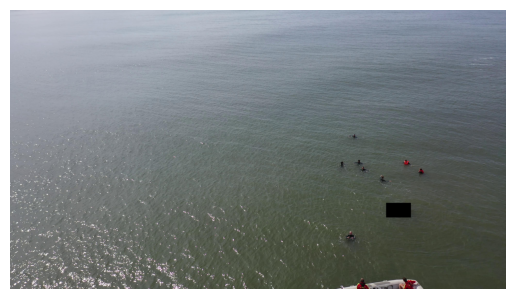

Ultralytics 8.3.101 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


100%|██████████| 755k/755k [00:00<00:00, 3.67MB/s]
val: Scanning /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/labels/test... 253 images, 0 backgrounds, 0 corrupt: 100%|██████████| 253/253 [00:01<00:00, 194.84it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.76it/s]


                   all        253       1363          0          0          0          0
                     0        253       1363          0          0          0          0


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.9ms preprocess, 3.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aa5b00de0e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.040

In [7]:
img = "/kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

metrics = model.val(
    data=data_file,
    split="test"
)

print(metrics)

# Fine-tuning

In [8]:
model.train(
    data=data_file,
    epochs=200,
    patience=10,
    imgsz=640,
    batch=16,
    name="yolo11_baseline_epoch"
)

!zip -r yolo11_baseline.zip /kaggle/working

Ultralytics 8.3.101 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/yolo11-baseline.yaml, data=/kaggle/working/data.yaml, epochs=200, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11_baseline_epoch, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cr

100%|██████████| 5.35M/5.35M [00:00<00:00, 16.9MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/labels/train... 2029 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2029/2029 [00:09<00:00, 209.56it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/train/9561.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/train/9564.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/train/9569.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/train/9570.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/train/9571.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/labels/val... 253 images, 0 backgrounds, 0 corrupt: 100%|██████████| 253/253 [00:01<00:00, 185.34it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/labels is not writeable, cache not saved.


Plotting labels to runs/detect/yolo11_baseline_epoch/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolo11_baseline_epoch
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.46G      3.985      48.58      2.838        106        640: 100%|██████████| 127/127 [00:45<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]

                   all        253       1267   0.000353     0.0158    0.00018    5.5e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.71G      3.491      3.735      1.437        116        640: 100%|██████████| 127/127 [00:44<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

                   all        253       1267       0.21       0.19     0.0744     0.0146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.71G      3.236       2.58      1.234        130        640: 100%|██████████| 127/127 [00:45<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.31it/s]


                   all        253       1267      0.341      0.248      0.151     0.0337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.71G      3.063      2.103      1.201        118        640: 100%|██████████| 127/127 [00:46<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.42it/s]

                   all        253       1267      0.365      0.301      0.201     0.0448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.71G      2.979      1.865       1.19         75        640: 100%|██████████| 127/127 [00:45<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

                   all        253       1267       0.42      0.331      0.252     0.0634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.71G      2.892        1.7      1.156        108        640: 100%|██████████| 127/127 [00:45<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.47it/s]


                   all        253       1267      0.508      0.363      0.316     0.0853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.71G      2.839      1.587      1.121        119        640: 100%|██████████| 127/127 [00:46<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.02it/s]

                   all        253       1267      0.505      0.373      0.321     0.0941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.71G      2.744      1.549      1.111        110        640: 100%|██████████| 127/127 [00:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]

                   all        253       1267      0.516      0.405       0.35      0.096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.71G      2.673      1.437      1.079        154        640: 100%|██████████| 127/127 [00:45<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]


                   all        253       1267      0.484      0.399      0.335     0.0964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.71G      2.637      1.401      1.088        119        640: 100%|██████████| 127/127 [00:45<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.91it/s]

                   all        253       1267      0.514      0.369      0.359      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.71G      2.614        1.4      1.093         90        640: 100%|██████████| 127/127 [00:45<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

                   all        253       1267      0.548      0.427      0.389      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.71G      2.578      1.361      1.079        125        640: 100%|██████████| 127/127 [00:45<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.58it/s]

                   all        253       1267      0.554      0.438       0.39      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.71G       2.55      1.315      1.062        123        640: 100%|██████████| 127/127 [00:45<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.29it/s]

                   all        253       1267      0.519      0.398      0.361      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.71G      2.544      1.323      1.067        122        640: 100%|██████████| 127/127 [00:45<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

                   all        253       1267      0.555      0.424      0.398       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.71G      2.513      1.282      1.045         96        640: 100%|██████████| 127/127 [00:46<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]

                   all        253       1267       0.58      0.429      0.412      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.71G      2.467      1.283      1.039        107        640: 100%|██████████| 127/127 [00:46<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.48it/s]

                   all        253       1267      0.527      0.412      0.391      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.71G      2.463      1.258      1.027        160        640: 100%|██████████| 127/127 [00:45<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.54it/s]

                   all        253       1267      0.585      0.409      0.398       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.71G      2.497      1.265      1.056        123        640: 100%|██████████| 127/127 [00:46<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

                   all        253       1267      0.565      0.425      0.407      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.71G      2.439       1.23      1.049         88        640: 100%|██████████| 127/127 [00:45<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.41it/s]

                   all        253       1267      0.616       0.45       0.44      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.71G      2.461      1.235      1.023        109        640: 100%|██████████| 127/127 [00:46<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]

                   all        253       1267      0.578       0.46      0.423      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.71G      2.431      1.232      1.055         76        640: 100%|██████████| 127/127 [00:46<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.19it/s]

                   all        253       1267      0.603      0.462      0.455      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.71G      2.414      1.203      1.038        102        640: 100%|██████████| 127/127 [00:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]

                   all        253       1267       0.62       0.48      0.467      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.71G      2.371      1.203      1.029        109        640: 100%|██████████| 127/127 [00:46<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.78it/s]

                   all        253       1267       0.61      0.465      0.467      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.71G      2.386       1.21       1.05        135        640: 100%|██████████| 127/127 [00:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.53it/s]

                   all        253       1267      0.575      0.452      0.434      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.71G      2.423      1.196      1.033         94        640: 100%|██████████| 127/127 [00:44<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.41it/s]

                   all        253       1267      0.586      0.466      0.449      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.71G      2.379      1.193      1.033         93        640: 100%|██████████| 127/127 [00:46<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.84it/s]

                   all        253       1267      0.584      0.467      0.456      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.71G      2.338      1.152      1.015        108        640: 100%|██████████| 127/127 [00:45<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]

                   all        253       1267      0.628       0.47      0.477      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.71G      2.298      1.126      1.023         86        640: 100%|██████████| 127/127 [00:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

                   all        253       1267      0.646      0.481      0.484      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.71G      2.329      1.157      1.022        121        640: 100%|██████████| 127/127 [00:45<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.91it/s]

                   all        253       1267      0.634      0.484      0.481      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.71G      2.323      1.138       1.02         84        640: 100%|██████████| 127/127 [00:46<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

                   all        253       1267      0.591      0.466      0.464      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.71G      2.321       1.14      1.027        132        640: 100%|██████████| 127/127 [00:45<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.46it/s]

                   all        253       1267      0.623      0.488      0.488      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.71G      2.275      1.124      1.019        115        640: 100%|██████████| 127/127 [00:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.43it/s]

                   all        253       1267      0.663      0.488      0.503      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.71G      2.281      1.126      1.009        137        640: 100%|██████████| 127/127 [00:46<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

                   all        253       1267      0.625      0.515      0.513      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.71G      2.294      1.129      1.017        125        640: 100%|██████████| 127/127 [00:47<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.77it/s]

                   all        253       1267      0.592      0.479      0.481      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.71G      2.288      1.112      1.015         78        640: 100%|██████████| 127/127 [00:45<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

                   all        253       1267      0.642      0.493      0.496      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.71G      2.258      1.093      1.004         65        640: 100%|██████████| 127/127 [00:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.07it/s]

                   all        253       1267      0.646      0.481      0.492      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.71G      2.237      1.099      1.013         89        640: 100%|██████████| 127/127 [00:46<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.27it/s]

                   all        253       1267      0.636        0.5      0.513      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.71G      2.265      1.104     0.9955         97        640: 100%|██████████| 127/127 [00:46<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

                   all        253       1267      0.639      0.494      0.499      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.71G      2.235      1.089      1.004        102        640: 100%|██████████| 127/127 [00:46<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.65it/s]

                   all        253       1267      0.646      0.503        0.5      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.71G      2.232      1.085     0.9967        117        640: 100%|██████████| 127/127 [00:46<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.49it/s]

                   all        253       1267      0.628      0.508      0.504      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.71G      2.254      1.095      1.001         92        640: 100%|██████████| 127/127 [00:46<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

                   all        253       1267      0.637      0.496      0.514      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.71G       2.24      1.078     0.9924        102        640: 100%|██████████| 127/127 [00:46<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]

                   all        253       1267      0.669      0.519      0.528      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.71G      2.223      1.079      1.008        108        640: 100%|██████████| 127/127 [00:46<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.59it/s]

                   all        253       1267      0.673       0.52      0.528      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.71G       2.24      1.086      1.011        111        640: 100%|██████████| 127/127 [00:48<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]

                   all        253       1267      0.662      0.505      0.519      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.71G       2.24      1.087       1.01        143        640: 100%|██████████| 127/127 [00:45<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        253       1267      0.666      0.493      0.506      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.71G      2.232       1.08     0.9982        130        640: 100%|██████████| 127/127 [00:46<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.14it/s]

                   all        253       1267      0.664      0.493      0.508      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.71G      2.223       1.08      1.004        106        640: 100%|██████████| 127/127 [00:46<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.50it/s]

                   all        253       1267      0.671      0.525      0.532      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.71G      2.191      1.059      1.003        107        640: 100%|██████████| 127/127 [00:46<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]

                   all        253       1267      0.629      0.507      0.502       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.71G      2.215      1.073      1.003         63        640: 100%|██████████| 127/127 [00:46<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]

                   all        253       1267      0.681      0.527      0.533       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.71G      2.228      1.066     0.9917        104        640: 100%|██████████| 127/127 [00:46<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]

                   all        253       1267      0.638      0.539      0.525      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.71G      2.207      1.049      1.001         89        640: 100%|██████████| 127/127 [00:46<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]


                   all        253       1267      0.654      0.528       0.52      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.71G      2.205       1.05     0.9774         91        640: 100%|██████████| 127/127 [00:47<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.22it/s]

                   all        253       1267       0.64      0.515      0.522      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.71G      2.183       1.04     0.9964         50        640: 100%|██████████| 127/127 [00:47<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]


                   all        253       1267      0.671       0.53      0.529      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.71G      2.197       1.06     0.9999        101        640: 100%|██████████| 127/127 [00:46<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]

                   all        253       1267       0.67      0.526      0.543      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.71G      2.144      1.032     0.9808        107        640: 100%|██████████| 127/127 [00:46<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.47it/s]

                   all        253       1267      0.694      0.503      0.525        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.71G      2.177      1.045      0.976         75        640: 100%|██████████| 127/127 [00:45<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

                   all        253       1267      0.694      0.511       0.54      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.71G      2.186      1.039     0.9816        102        640: 100%|██████████| 127/127 [00:45<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.36it/s]

                   all        253       1267      0.644      0.508      0.533      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.71G      2.163      1.051     0.9946         92        640: 100%|██████████| 127/127 [00:46<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        253       1267       0.66      0.519       0.52      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      2.71G      2.152      1.027     0.9867        113        640: 100%|██████████| 127/127 [00:47<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.10it/s]

                   all        253       1267      0.668      0.531      0.533      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.71G      2.138      1.019     0.9936        158        640: 100%|██████████| 127/127 [00:46<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.25it/s]


                   all        253       1267      0.648      0.515      0.533      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.71G      2.121      1.014     0.9838        101        640: 100%|██████████| 127/127 [00:47<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.33it/s]

                   all        253       1267      0.679      0.534      0.548      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.71G      2.144      1.005     0.9749         98        640: 100%|██████████| 127/127 [00:47<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.59it/s]

                   all        253       1267      0.674      0.537      0.549      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.71G      2.139      1.007     0.9871         98        640: 100%|██████████| 127/127 [00:46<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

                   all        253       1267      0.693      0.523      0.549      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.71G      2.155      1.012     0.9809        101        640: 100%|██████████| 127/127 [00:46<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

                   all        253       1267      0.672      0.531       0.54      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.71G      2.105     0.9771     0.9742         98        640: 100%|██████████| 127/127 [00:46<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]

                   all        253       1267      0.698      0.511       0.55       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.71G      2.142      1.015     0.9873        125        640: 100%|██████████| 127/127 [00:46<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.64it/s]

                   all        253       1267      0.684      0.497      0.533      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.71G      2.117      1.002     0.9861        108        640: 100%|██████████| 127/127 [00:47<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.53it/s]

                   all        253       1267      0.681      0.527      0.549      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.71G      2.094     0.9998     0.9883         92        640: 100%|██████████| 127/127 [00:46<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.61it/s]

                   all        253       1267      0.664      0.526      0.537      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.71G      2.155      1.012     0.9835         79        640: 100%|██████████| 127/127 [00:47<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

                   all        253       1267      0.681      0.525      0.549      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.71G       2.16      1.018     0.9757        126        640: 100%|██████████| 127/127 [00:46<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

                   all        253       1267      0.677      0.533      0.547       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.71G      2.123      1.016     0.9671        104        640: 100%|██████████| 127/127 [00:47<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.47it/s]

                   all        253       1267      0.693      0.537      0.553      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.71G      2.096     0.9925     0.9698        119        640: 100%|██████████| 127/127 [00:47<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.61it/s]

                   all        253       1267       0.69      0.533      0.549      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.71G       2.13     0.9947     0.9738        126        640: 100%|██████████| 127/127 [00:48<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]

                   all        253       1267      0.714      0.532      0.554      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.71G      2.084     0.9762     0.9768        101        640: 100%|██████████| 127/127 [00:47<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.29it/s]

                   all        253       1267      0.699      0.543      0.557      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.71G      2.094     0.9814     0.9874        122        640: 100%|██████████| 127/127 [00:47<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

                   all        253       1267       0.69      0.537      0.544      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.71G      2.106     0.9935     0.9797        121        640: 100%|██████████| 127/127 [00:46<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.61it/s]

                   all        253       1267      0.684       0.52      0.551      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.71G        2.1     0.9914     0.9716        146        640: 100%|██████████| 127/127 [00:45<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]

                   all        253       1267      0.687      0.536      0.555      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.71G      2.111      0.998     0.9794        100        640: 100%|██████████| 127/127 [00:46<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]

                   all        253       1267      0.716      0.552      0.561      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.71G      2.089     0.9763     0.9752        106        640: 100%|██████████| 127/127 [00:46<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.47it/s]

                   all        253       1267      0.723      0.537      0.569      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.71G      2.111     0.9931     0.9838         91        640: 100%|██████████| 127/127 [00:47<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.78it/s]

                   all        253       1267      0.699      0.552      0.564      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.71G      2.083     0.9827     0.9756        125        640: 100%|██████████| 127/127 [00:45<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.66it/s]


                   all        253       1267       0.69      0.547      0.553      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.71G      2.051     0.9602     0.9783         89        640: 100%|██████████| 127/127 [00:46<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.77it/s]

                   all        253       1267      0.696       0.52      0.549      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.71G      2.087     0.9713     0.9855        103        640: 100%|██████████| 127/127 [00:46<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.80it/s]

                   all        253       1267      0.709       0.54       0.56      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.71G      2.075     0.9626     0.9731         77        640: 100%|██████████| 127/127 [00:46<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]


                   all        253       1267      0.697      0.533      0.551      0.222
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 74, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

84 epochs completed in 1.154 hours.
Optimizer stripped from runs/detect/yolo11_baseline_epoch/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo11_baseline_epoch/weights/best.pt, 5.5MB

Validating runs/detect/yolo11_baseline_epoch/weights/best.pt...
Ultralytics 8.3.101 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11-baseline summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


                   all        253       1267      0.698      0.544      0.556      0.226


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/yolo11_baseline_epoch
  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/yolo11_baseline_epoch/ (stored 0%)
  adding: kaggle/working/runs/detect/yolo11_baseline_epoch/val_batch1_pred.jpg (deflated 8%)
  adding: kaggle/working/runs/detect/yolo11_baseline_epoch/results.csv (deflated 62%)
  adding: kaggle/working/runs/detect/yolo11_baseline_epoch/train_batch1.jpg (deflated 4%)
  adding: kaggle/working/runs/detect/yolo11_baseline_epoch/args.yaml (deflated 54%)
  adding: kaggle/working/runs/detect/yolo11_baseline_epoch/val_batch2_pred.jpg (deflated 9%)
  adding: kaggle/working/runs/detect/yolo11_baseline_epoch/confusion_matrix.png (deflated 38%)
  adding: kaggle/working/runs/detect/yolo11_baseline_epoch/train_batch0.jpg (deflated 5%)
  adding: kaggle/working/runs/det

# Testing

In [9]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/test/10209.jpg: 384x640 7 humans, 15.4ms
Speed: 2.6ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


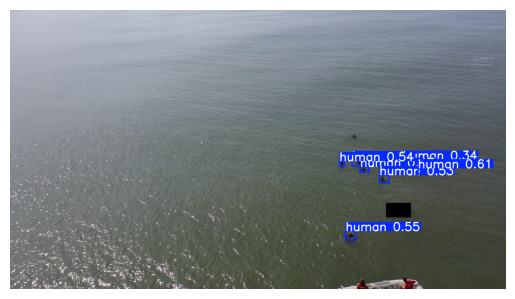

Ultralytics 8.3.101 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/labels/test... 253 images, 0 backgrounds, 0 corrupt: 100%|██████████| 253/253 [00:00<00:00, 637.36it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]


                   all        253       1363      0.709      0.607      0.605      0.248


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.2ms preprocess, 2.7ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aa389eea080>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04

In [10]:
model = YOLO("/kaggle/working/runs/detect/yolo11_baseline_epoch/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-2029/seaDronesSee_yolo/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

metrics = model.val(
    data=data_file,
    split="test"
)

print(metrics)